In [15]:
import folium
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from pyffp import calc_footprint_FFP_climatology as myfootprint

from pyffp.utils import get_dd
from pyffp.utils import contour_to_gdf

In [16]:
def read_l3(filepath):
    df = (pd.read_csv(filepath, header=0, low_memory=False)
      .replace(-9999, np.nan)
      .assign(date = lambda x: pd.to_datetime(x['DATE']))
      .set_index('date')
     )
    df.index = df.index.set_names(None)
    return df

filepath = '/home/otto/data/atmos-flux-data/processed/ATMOS_L3_2023-04-25.csv'

l3 = read_l3(filepath)

predictors = 'baseflux'

filepath = f'/home/otto/data/atmos-flux-data/methane-gapfill/data_dir/ATMOS_20230425_{predictors}/gapfilled/rf_predictors_laplace.csv'


filepath = '/home/otto/data/atmos-flux-data/processed/ATMOS_L1_fluxnet_2023-04-10.csv'
l1_fluxnet = read_l3(filepath)


l3['V_SIGMA'] = l1_fluxnet.loc[l1_fluxnet.index == l3.index, 'V_SIGMA']

In [134]:
ffpdate = '2022'
df = l3.loc[ffpdate]
df = df.loc[df['L'].notna()]

z_tower = 4
hei = 1.5
z0t = 0.15 * hei
d = 0.67 * hei
ht = 750 * np.ones(len(df))
ht = ht.tolist()

zmt = (z_tower - d) * np.ones(len(df))
zmt = zmt.tolist()

olt = df['L'].tolist()
sigmavt = df['V_SIGMA'].tolist()
ustart = df['u.'].tolist()
wind_dirt = df['wind_dir'].tolist()
domaint = [-100.0, 1000.0, -100.0, 1000.0]
nxt = 1100
# rst = [20.0, 40.0, 60.0, 80.0]
rst = [50.0, 80.0]

In [135]:
# generate footprints
FFP = myfootprint.FFP_climatology(
    zm=zmt,
    z0=z0t,
    umean=None,
    h=ht,
    ol=olt,
    sigmav=sigmavt,
    ustar=ustart,
    wind_dir=wind_dirt,
    domain=domaint,
    nx=nxt,
    rs=rst,
    smooth_data=1
)


Alert(0013):
 Using z0, ignoring umean if passed.
 Execution continues.

Calculating footprint  1  of  6467
Calculating footprint  324  of  6467
Calculating footprint  647  of  6467
Calculating footprint  970  of  6467
Calculating footprint  1293  of  6467
Calculating footprint  1616  of  6467
Calculating footprint  1939  of  6467
Calculating footprint  2262  of  6467
Calculating footprint  2585  of  6467
Calculating footprint  2908  of  6467
Calculating footprint  3231  of  6467
Calculating footprint  3554  of  6467
Calculating footprint  3877  of  6467
Calculating footprint  4200  of  6467
Calculating footprint  4523  of  6467
Calculating footprint  4846  of  6467
Calculating footprint  5169  of  6467
Calculating footprint  5492  of  6467
Calculating footprint  5815  of  6467
Calculating footprint  6138  of  6467
Calculating footprint  6461  of  6467


In [136]:
# georeference grids
x_2d = FFP["x_2d"]
y_2d = FFP["y_2d"]
# set the origin at the SE-Nor station
origin_lon = -87.996285
origin_lat = 41.701827
x_2d_dd = np.vectorize(get_dd)(x_2d) + origin_lon
y_2d_dd = np.vectorize(get_dd)(y_2d) + origin_lat

In [137]:
# prepare contour inputs
clevs = FFP["fr"][::-1]
clevs = [clev for clev in clevs if clev is not None]
levs = [clev for clev in clevs]
fs = FFP["fclim_2d"]
cs = [cm.jet(ix) for ix in np.linspace(0, 1, len(fs))]
f = fs[0]
c = cs[0]
cc = [c]*len(levs)

In [138]:
# generate GeoDataFrame of contours
fig, ax = plt.subplots(figsize=(10, 8))
cp = ax.contour(x_2d_dd, y_2d_dd, fs, levs, colors = cc, linewidths=0.5)
gdf = contour_to_gdf(cp)
plt.close()

In [139]:
# plotting
origin = gpd.GeoDataFrame(
    {"site": "SE-Nor"},
    geometry=gpd.points_from_xy(x=[origin_lon], y=[origin_lat]),
    crs=4326,
    index=[0],
).to_json()
origin = folium.features.GeoJson(origin)

contours = gdf.to_json()
contours = folium.features.GeoJson(contours)

m = folium.Map(location=[origin_lat, origin_lon], zoom_start=16)
m.add_child(origin)
m.add_child(contours)

tile = folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = False,
        control = True
       ).add_to(m)

m.save(f'/home/otto/data/atmos-flux-data/output/html/atmos_ffp_esri_{ffpdate}')
m

In [91]:
# plotting
origin = gpd.GeoDataFrame(
    {"site": "SE-Nor"},
    geometry=gpd.points_from_xy(x=[origin_lon], y=[origin_lat]),
    crs=4326,
    index=[0],
).to_json()
origin = folium.features.GeoJson(origin)

contours = gdf.to_json()
contours = folium.features.GeoJson(contours)

map_osm = folium.Map(location=[origin_lat, origin_lon], zoom_start=16)
map_osm.add_child(origin)
map_osm.add_child(contours)
map_osm.save('/home/otto/data/atmos-flux-data/output/html/atmos_ffp_osm_2022-06')
map_osm

In [3]:
# define footprint inputs
zmt = 20.0
z0t = 0.01
ht = [2000.0, 1800.0, 1500.0]
olt = [-10.0, -100.0, -500.0]
sigmavt = [
    0.9,
    0.7,
    0.3,
]
ustart = [0.5, 0.3, 0.4]
wind_dirt = [30.0, 50.0, 70.0]
domaint = [-100.0, 1000.0, -100.0, 1000.0]
nxt = 1100
rst = [20.0, 40.0, 60.0, 80.0]

In [4]:
# generate footprints
FFP = myfootprint.FFP_climatology(
    zm=zmt,
    z0=z0t,
    umean=None,
    h=ht,
    ol=olt,
    sigmav=sigmavt,
    ustar=ustart,
    wind_dir=wind_dirt,
    domain=domaint,
    nx=nxt,
    rs=rst,
    smooth_data=1
)


Alert(0017):
 Only one value of zm passed. Using it for all footprints.
 Execution continues.

Alert(0013):
 Using z0, ignoring umean if passed.
 Execution continues.

Calculating footprint  1  of  3
Calculating footprint  2  of  3
Calculating footprint  3  of  3


In [21]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
from matplotlib import pyplot as plt
# import seaborn as sns
# import zipfile
# from cycler import cycler
# from FFP_Python import calc_footprint_FFP as myfootprint
# import FFP_Python
# from FFP_Python import utils
# from FFP_Python.utils import contour_to_gdf

pd.options.display.float_format = '{:.4f}'.format


# global plotting settings
plt.style.use(['ggplot'])

# default_cycler = (plt.rcParams['axes.prop_cycle'][:4]  +
#                   cycler(linestyle=['-', '--', ':', '-.']))

plt.rcParams.update({'axes.grid' : True, 
                     'axes.facecolor' : 'white', 
                     'axes.edgecolor' : '.15',
                     'axes.labelcolor' : 'black',
                     'yaxis.labellocation' : 'center',
                     'lines.marker' : '.',
                     'lines.linestyle' : 'None',
                     'grid.color' : '.8',
#                      'axes.prop_cycle' : default_cycler,
                     'figure.figsize' : (10*1.8, 5.65*1.8)
                    })

# plt.rc('axes', prop_cycle=default_cycler)

data_dir = f'/home/otto/data/atmos-flux-data/methane-gapfill/data_dir/'


# Plot L3 fluxes

## Calculate footprint

In [10]:
df = l3.loc['2022-06-01 11:00']

z_tower = 4
hei = 1.5
z0 = 0.15 * hei
d = 0.67 * hei
h = 750

zm = z_tower - d

ol = df['L']
sigmav = df['V_SIGMA']
ustar = df['u.']

ol

FFP = myfootprint.FFP(zm = zm, z0 = z0, h = 750, ol = df['L'], sigmav = df['V_SIGMA'], ustar = df['u.'])

-18.7401

AttributeError: module 'FFP_Python' has no attribute 'utils'

In [18]:
# georeference grids
x_2d = FFP["x_2d"]
y_2d = FFP["y_2d"]
# set the origin at the SE-Nor station
origin_lon = 17.4795
origin_lat = 60.0865
x_2d_dd = np.vectorize(get_dd)(x_2d) + origin_lon
y_2d_dd = np.vectorize(get_dd)(y_2d) + origin_lat

{'x_ci_max': 5.607212151686834,
 'x_ci': array([  1.06797608,   1.26022529,   1.45247451, ..., 192.93269067,
        193.12493989, 193.3171891 ]),
 'f_ci': array([1.27434434e-19, 1.40723523e-09, 2.21419353e-06, ...,
        2.48741212e-04, 2.48258294e-04, 2.47776782e-04]),
 'x_2d': array([[  1.06797608,   1.06797608,   1.06797608, ...,   1.06797608,
           1.06797608,   1.06797608],
        [  1.26022529,   1.26022529,   1.26022529, ...,   1.26022529,
           1.26022529,   1.26022529],
        [  1.45247451,   1.45247451,   1.45247451, ...,   1.45247451,
           1.45247451,   1.45247451],
        ...,
        [192.93269067, 192.93269067, 192.93269067, ..., 192.93269067,
         192.93269067, 192.93269067],
        [193.12493989, 193.12493989, 193.12493989, ..., 193.12493989,
         193.12493989, 193.12493989],
        [193.3171891 , 193.3171891 , 193.3171891 , ..., 193.3171891 ,
         193.3171891 , 193.3171891 ]]),
 'y_2d': array([[-144.18690976, -143.99466055, -143.802

In [145]:
pd.DataFrame(FFP)

ValueError: Per-column arrays must each be 1-dimensional

In [130]:
if None in [zm, 750, [df['L'].values] ]:
    print('yes')

In [138]:
FFP = ffp.FFP(zm = zm, z0 = z0, 
                          h = 750, 
                          ol = ol,
                          sigmav = sigmav,
                          ustar = ustar
                         )

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

## Annual metrics

In [33]:
l3.loc[:, l3.columns.str.contains('model')]

,model
2022-05-24 10:30:00,0.0000
2022-05-24 11:00:00,0.0000
2022-05-24 11:30:00,NaN
2022-05-24 12:00:00,NaN
2022-05-24 12:30:00,0.0000
...,...
2023-04-06 09:30:00,0.0000
2023-04-06 10:00:00,0.0000
2023-04-06 10:30:00,0.0000
2023-04-06 11:00:00,0.0000


In [6]:
annualmean = l3[['ch4_flux','co2_flux','TA_EP','Precip','T60']].mean(axis=0)
annualmean

ch4_flux     -0.0029
co2_flux     -1.9911
TA_EP        12.5219
Precip        0.1156
T60        1066.9221
dtype: float64

In [7]:
annualsum = l3[['ch4_flux','co2_flux','Precip']].sum(axis=0)
annualsum

ch4_flux      -16.2479
co2_flux   -16503.9427
Precip        810.8000
dtype: float64

In [53]:
cols = ['ch4_flux','FCH4_f', 'FCH4_F_ANN', 'FCH4_F_RF', 'co2_flux', 'NEE_f', 'GPP_f', 'Reco','Precip']
annualsumnorm = l3[cols].sum(axis=0) / l3[cols].notna().sum(axis=0)*2*24*365
annualsumnorm

ch4_flux        -50.9056
FCH4_f          -26.7542
FCH4_F_ANN   -29325.0759
FCH4_F_RF       -20.3210
co2_flux     -34883.4691
NEE_f          -986.3921
GPP_f         96110.1759
Reco          95123.7838
Precip         2025.2660
dtype: float64

In [54]:
# cols = ['FC', 'NEE_f', 'Reco', 'GPP_f', 'FCH4', 'FCH4_f', 'H_f'] # Fluxnet variables
cols = ['co2_flux', 'NEE_f', 'Reco', 'GPP_f', 'ch4_flux', 'FCH4_f', 'FCH4_F_RF', 'FCH4_F_ANN', 'LE', 'LE_f','H_f'] # Full output variables

dailysum = l3.loc[:, cols].groupby(pd.Grouper(freq='1D')).sum() * 1800 / 1000
dailysum.loc[:, 'LE_f'] = l3.loc[:, ['LE_f']].groupby(pd.Grouper(freq='1D')).sum()

In [55]:
daily = l3.loc[:, cols].groupby(l3.index.floor('D')).mean()
# daily[['FCH4', 'FCH4_f', 'FCH4_F_ANN']]
# daily.loc[:,'FCH4']
daily

,co2_flux,NEE_f,Reco,GPP_f,ch4_flux,FCH4_f,FCH4_F_RF,FCH4_F_ANN,LE,LE_f,H_f
2022-05-24,-5.7456,-6.5086,8.4308,14.9394,-0.0049,-0.0055,-0.0068,-1.8061,138.6099,146.4370,70.3890
2022-05-25,3.6290,0.6878,8.9215,8.2338,-0.0079,-0.0033,-0.0045,-0.0053,63.8297,81.0091,-11.3800
2022-05-26,-2.8393,0.1329,9.3798,9.2469,0.0093,0.0032,0.0073,0.0075,87.3695,70.6887,-11.6743
2022-05-27,1.6831,0.1979,8.3872,8.1893,-0.0359,-0.0091,-0.0103,-0.0037,67.7102,70.0475,-2.6037
2022-05-28,-11.5751,-5.2808,8.8048,14.0856,-0.0142,-0.0058,-0.0077,-1.5251,189.8657,134.7602,23.8026
...,...,...,...,...,...,...,...,...,...,...,...
2023-04-02,-1.3752,-0.3161,3.1527,3.4688,-0.0007,-0.0002,-0.0002,0.0001,48.5438,36.9962,67.5145
2023-04-03,2.2016,1.8153,3.8432,2.0280,0.0018,0.0019,0.0000,0.0014,54.2224,49.2886,8.5554
2023-04-04,3.7629,2.4669,4.0292,1.5622,0.0056,0.0039,0.0029,-0.5032,30.5669,31.5251,8.5940
2023-04-05,1.8673,1.7657,4.3560,2.5904,-0.0033,-0.0017,-0.0015,-0.0018,54.5584,53.7430,-21.2904


## Plot daily means over half-hours

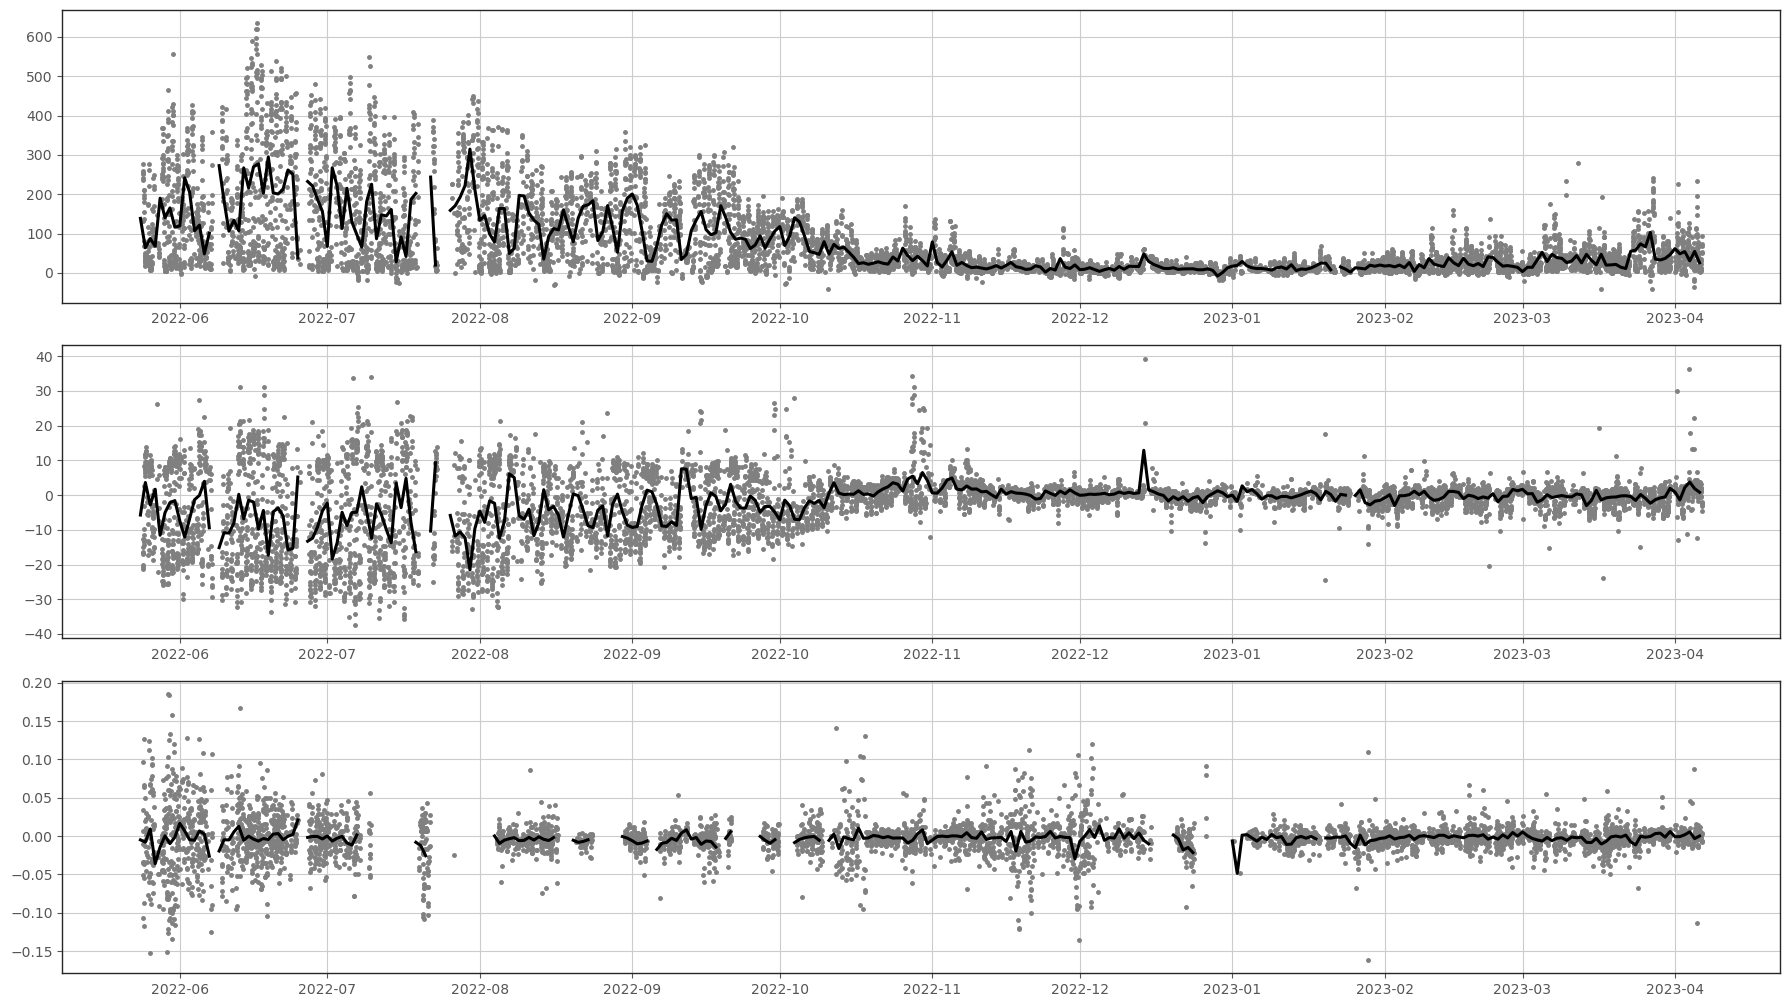

In [56]:
fig, ax = plt.subplots(3,1,figsize=(10*1.8, 5.65*1.8))

ax[0].plot(l3['LE'], alpha = 1, ms = 5, ls = '', color = 'gray')
ax[0].plot(daily['LE'], marker = '', lw = 2.2, color = 'k')

ax[1].plot(l3['co2_flux'], alpha = 1, ms = 5, ls = '', color = 'gray')
ax[1].plot(daily['co2_flux'], marker = '', lw = 2.2, color = 'k')

ax[2].plot(l3['ch4_flux'], alpha = 1, ms = 5, ls = '', color = 'gray')
ax[2].plot(daily['ch4_flux'], marker = '', lw = 2.2, color = 'k')

plt.tight_layout()

# plt.savefig(f'./output/atmos_L3fluxes_{datetime.now().strftime("%Y%m%d")}_dailymean.png', dpi=300)


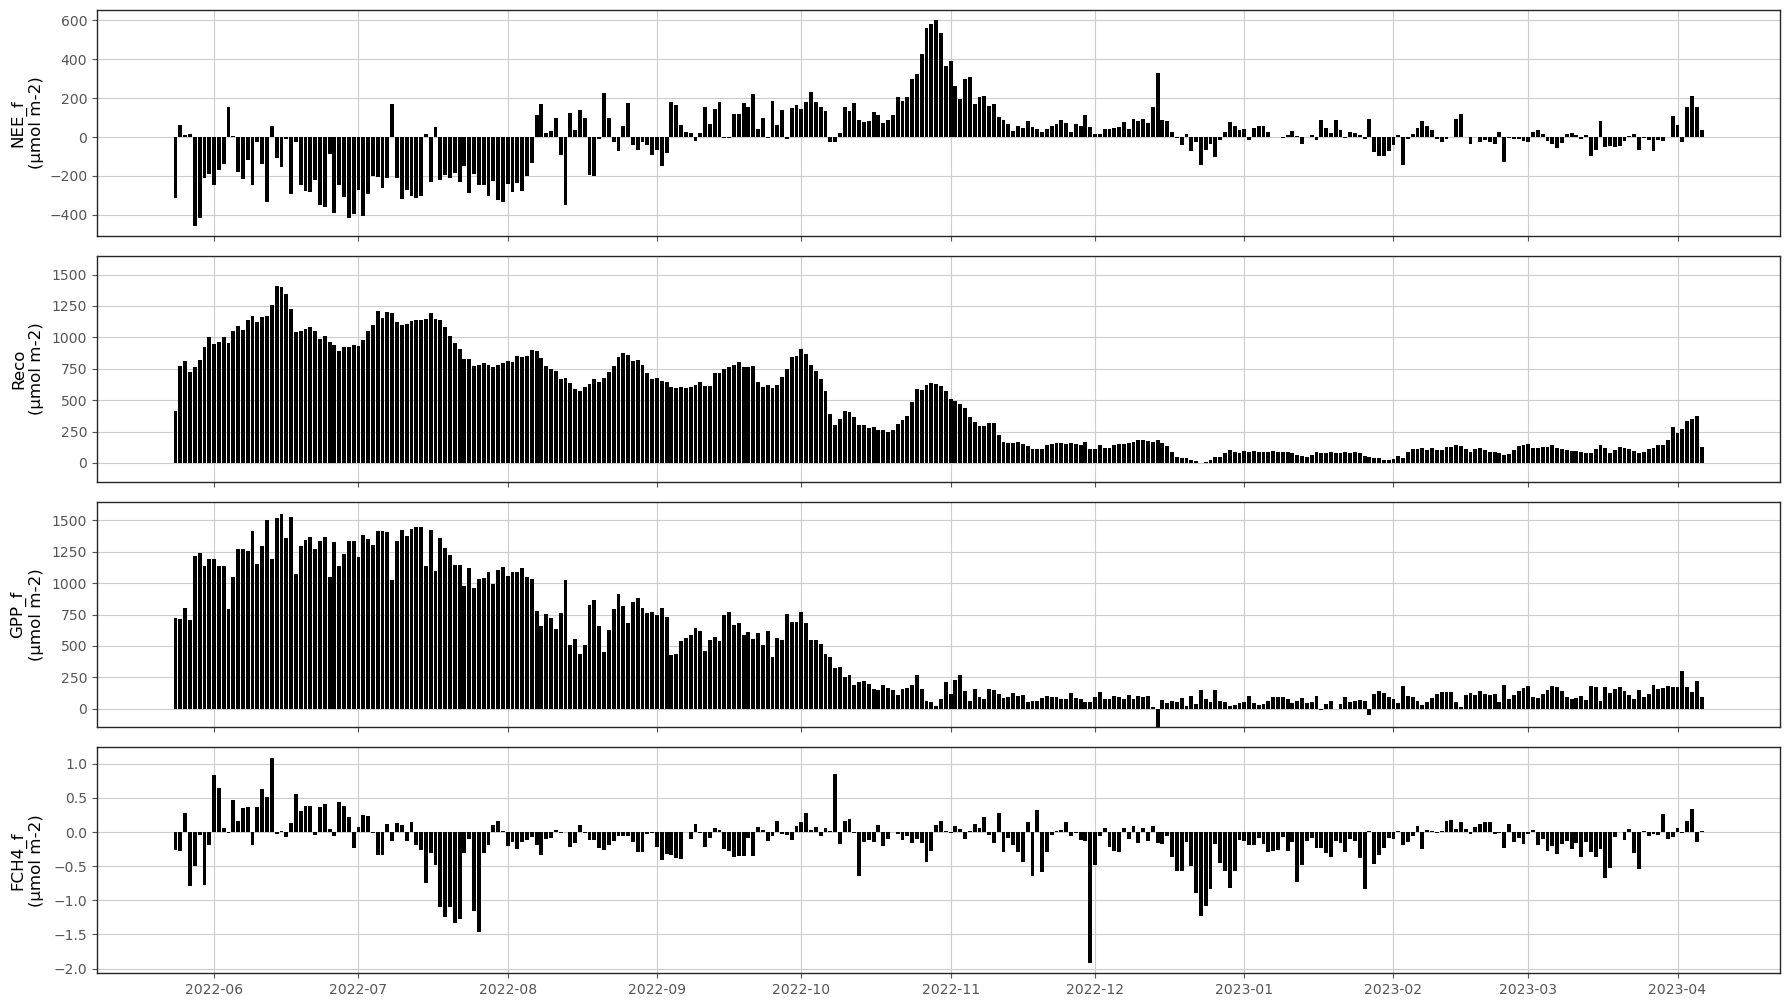

In [57]:
# cols = ['NEE_f', 'Reco', 'GPP_f', 'FCH4_f']
cols = ['NEE_f', 'Reco', 'GPP_f', 'FCH4_f']

fig, ax = plt.subplots(len(cols),1, figsize = (10*1.8, 5.65*1.8), sharex = True)

for i in range(len(cols)):
    ax[i].bar(dailysum.index, dailysum[cols[i]], color = 'k', linestyle = 'None')
    ax[i].set(ylabel = cols[i] + '\n(µmol m-2)')
    
ax[1].set(ylim = [-150,1650])
ax[2].set(ylim = [-150,1650])
plt.tight_layout()
fig.align_ylabels(ax[:])

# plt.savefig(f'./output/atmos_L3fluxes_{datetime.now().strftime("%Y%m%d")}_gapfilled.png', dpi=300)


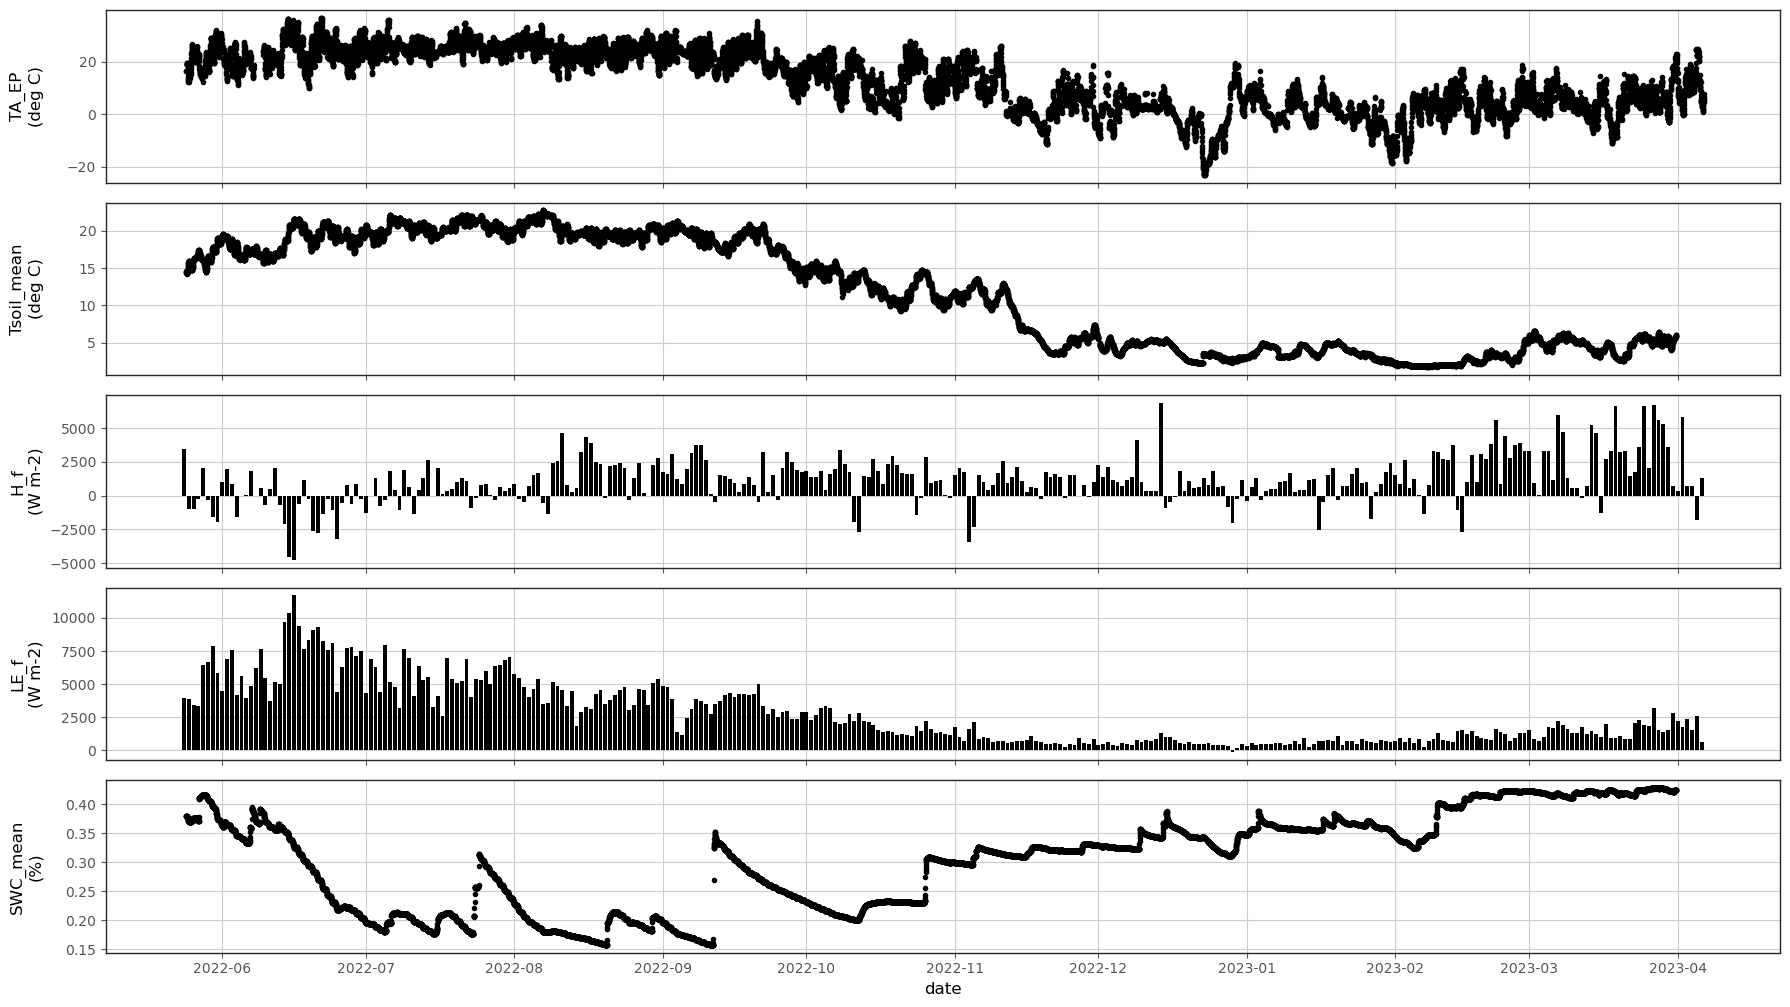

In [58]:
cols = ['TA_EP', 'Tsoil_mean', 'H_f', 'LE_f', 'SWC_mean']

fig, ax = plt.subplots(len(cols),1, figsize = (10*1.8, 5.65*1.8), sharex = True)

ax[0].plot(l3[cols[0]], color = 'k', linestyle='None')
ax[1].plot(l3[cols[1]], color = 'k', linestyle='None')
ax[2].bar(dailysum.index, dailysum[cols[2]], color = 'k', linestyle='None')
ax[3].bar(dailysum.index, dailysum[cols[3]], color = 'k', linestyle='None')
ax[4].plot(l3[cols[4]], color = 'k', linestyle='None')

ax[0].set(ylabel = cols[0] + '\n(deg C)')
ax[1].set(ylabel = cols[1] + '\n(deg C)')
ax[2].set(ylabel = cols[2] + '\n(W m-2)')
ax[3].set(ylabel = cols[3] + '\n(W m-2)')
ax[4].set(ylabel = cols[4] + '\n(%)', xlabel = 'date')

plt.tight_layout()
fig.align_ylabels(ax[:])
# plt.savefig(f'./output/atmos_L3met_{datetime.now().strftime("%Y%m%d")}.png', dpi=300)

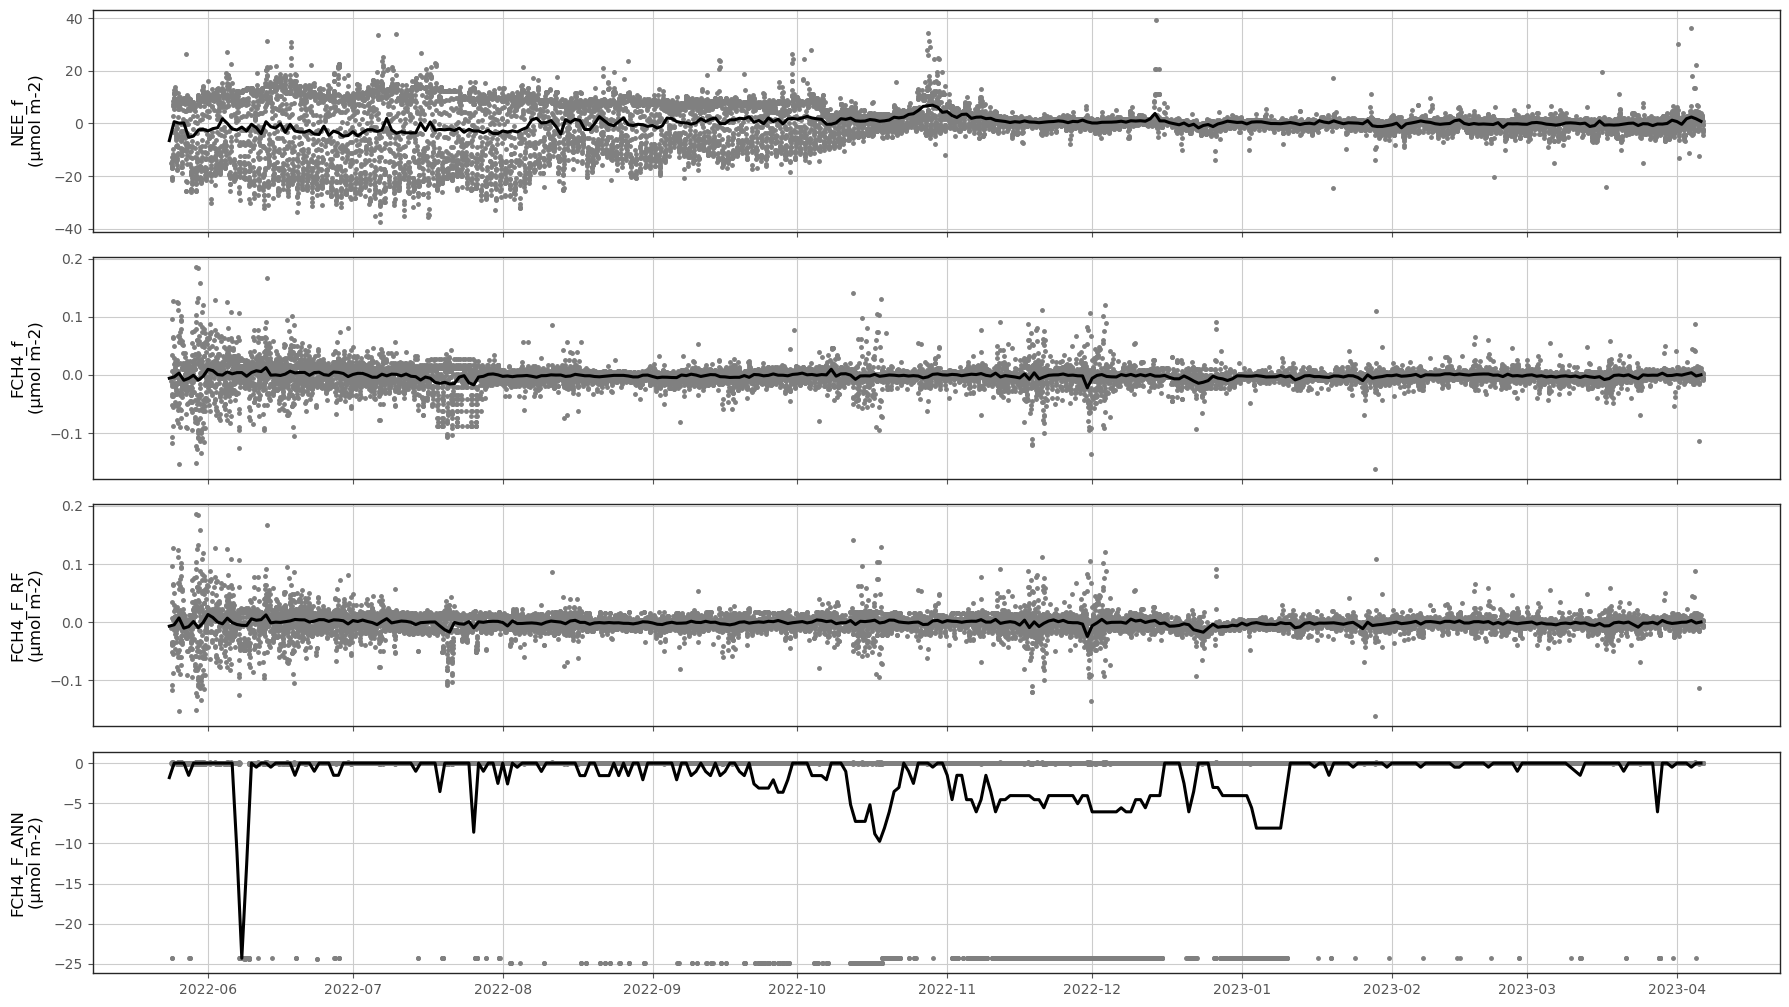

In [61]:
# cols = ['NEE_f', 'Reco', 'GPP_f', 'FCH4_f']
cols = ['NEE_f', 'FCH4_f', 'FCH4_F_RF', 'FCH4_F_ANN']

fig, ax = plt.subplots(len(cols),1, figsize = (10*1.8, 5.65*1.8), sharex = True)

for i in range(len(cols)):
    ax[i].plot(l3[cols[i]], alpha = 1, ms = 5, ls = '', color = 'gray')
    ax[i].plot(daily[cols[i]], marker = '', lw = 2.2, color = 'k')
    ax[i].set(ylabel = cols[i] + '\n(µmol m-2)')


# ax[3].set(ylim=[-1000, 1000])
plt.tight_layout()
fig.align_ylabels(ax[:])

# plt.savefig(f'./output/atmos_L3fluxes_{datetime.now().strftime("%Y%m%d")}_ch4models.png', dpi=300)


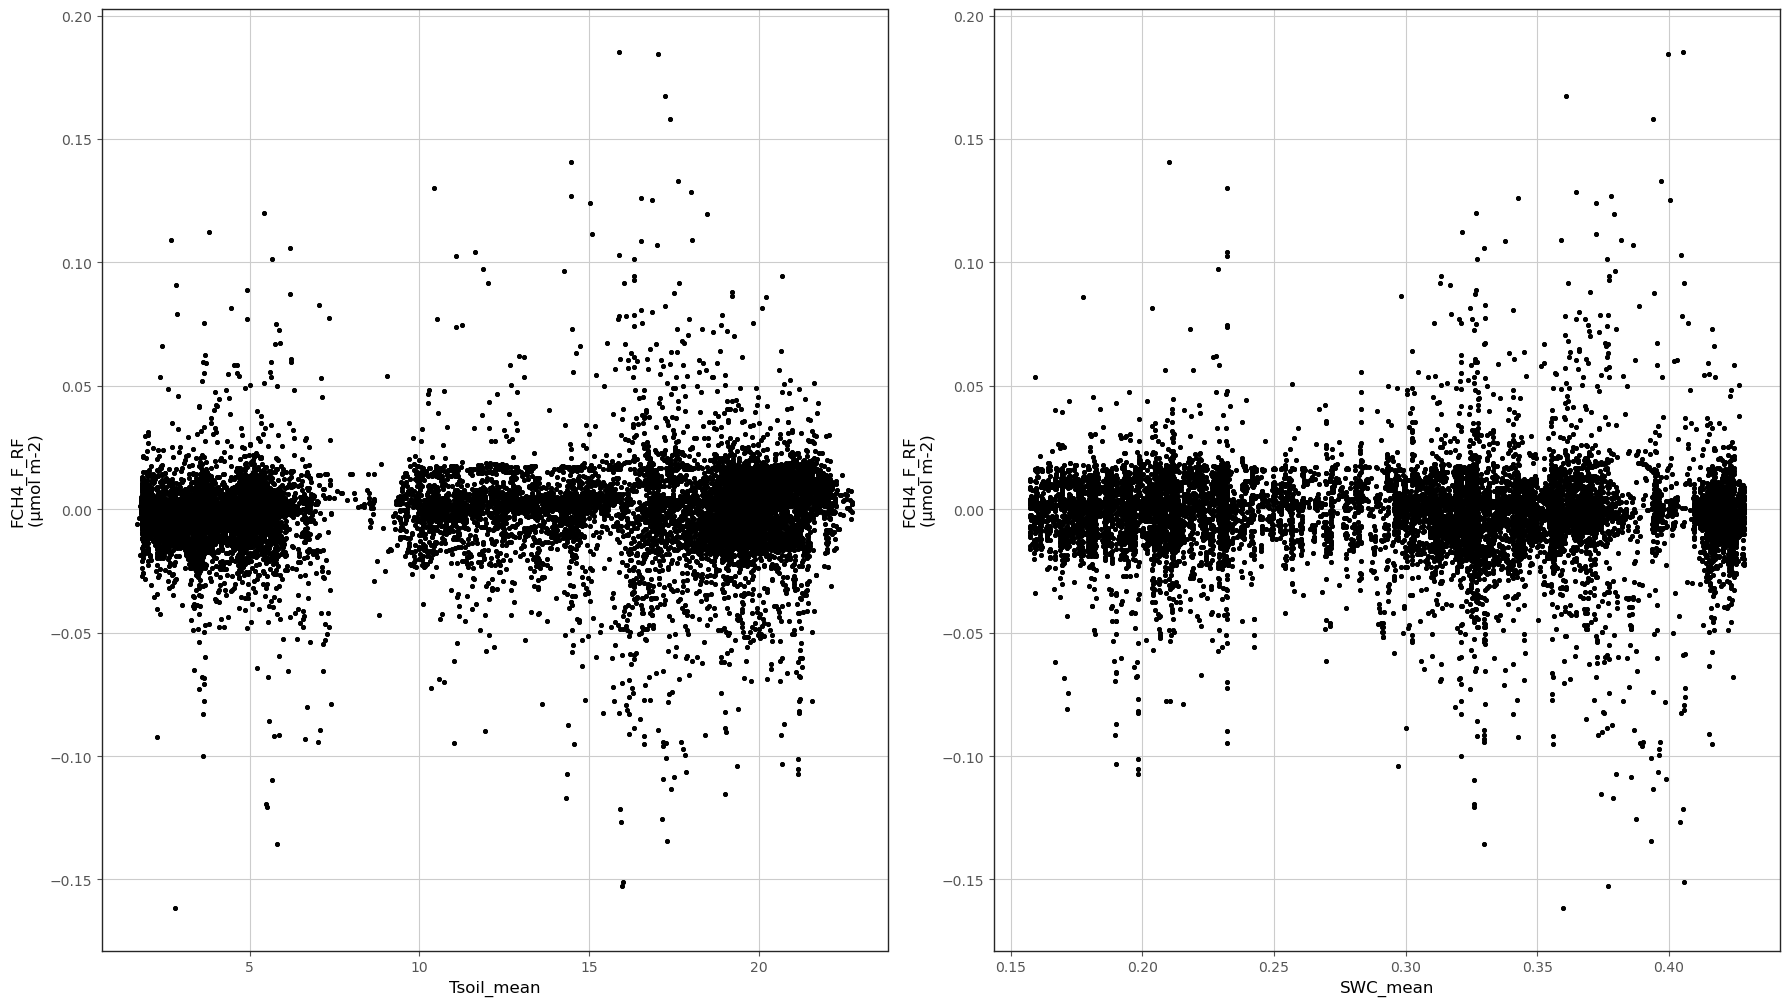

In [104]:
# cols = ['NEE_f', 'LE_f' 'FCH4_f', 'FCH4_F_RF']
cols = ['Tsoil_mean', 'SWC_mean']
fluxes = ['FCH4_f', 'FCH4_F_RF']
flux = fluxes[1]
fig, ax = plt.subplots(1,2)


for i in range(len(ax)):
    ax[i].plot(l3[cols[i]], l3[flux], ms = 5, ls='', color = 'k')
    ax[i].plot(l3[cols[i]], l3[flux], ms = 5, ls='', color = 'k')
    ax[i].set(xlabel = cols[i], ylabel = flux + '\n(µmol m-2)')
plt.tight_layout()
# plt.savefig(f'./output/atmos_L3fluxes_{datetime.now().strftime("%Y%m%d")}_{flux}vsTsoilSWC.png', dpi=300)

<AxesSubplot:xlabel='Tsoil_mean', ylabel='SWC_mean'>

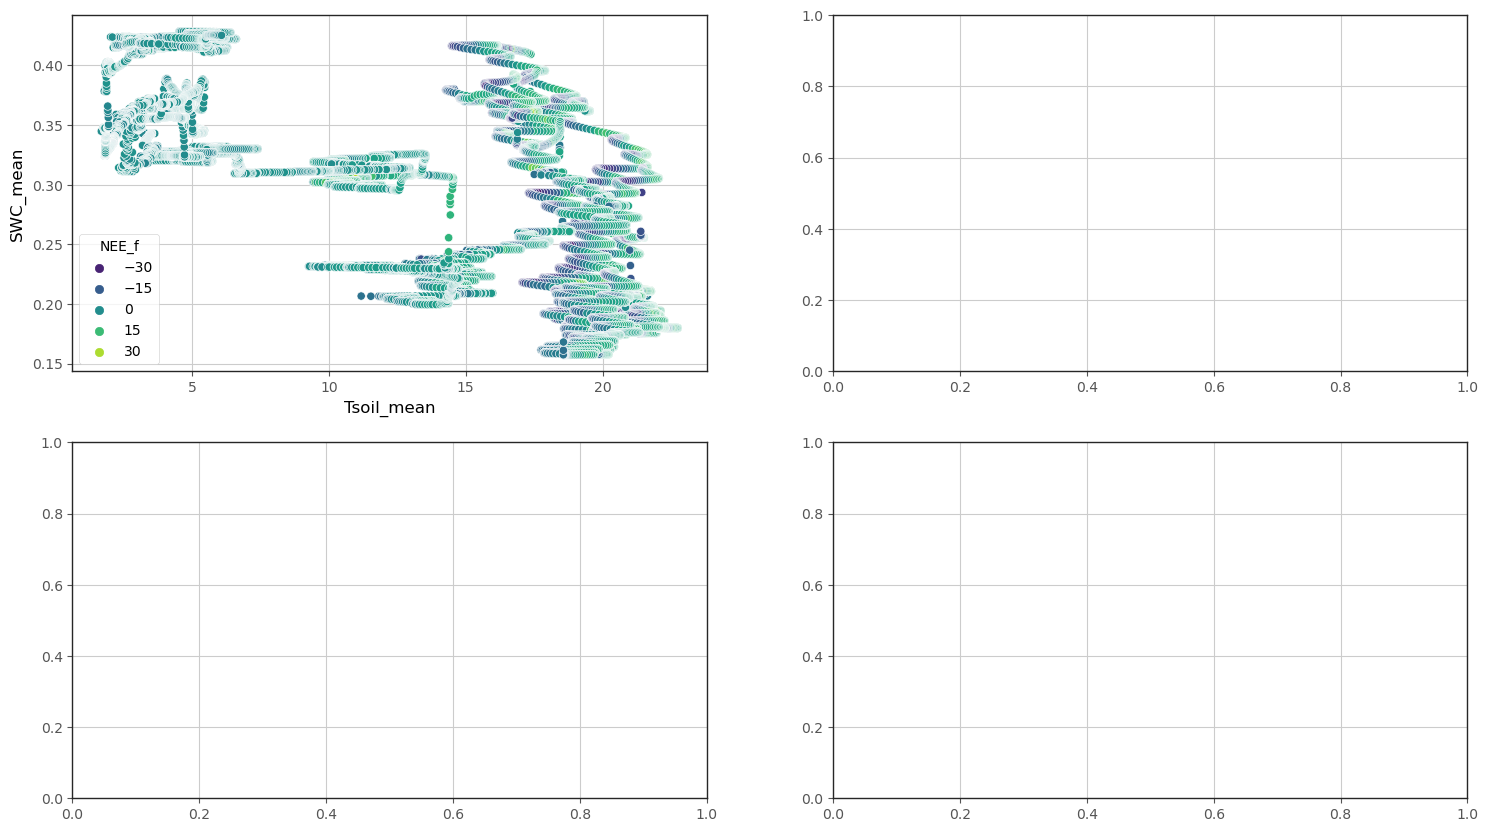

In [82]:
cols = ['NEE_f', 'LE_f' 'FCH4_f', 'FCH4_F_RF']

fig, ax = plt.subplots(2,2)

sns.scatterplot(data=l3, x = 'Tsoil_mean', y = 'SWC_mean', hue = cols[0], palette = 'viridis', ax = ax[0,0])

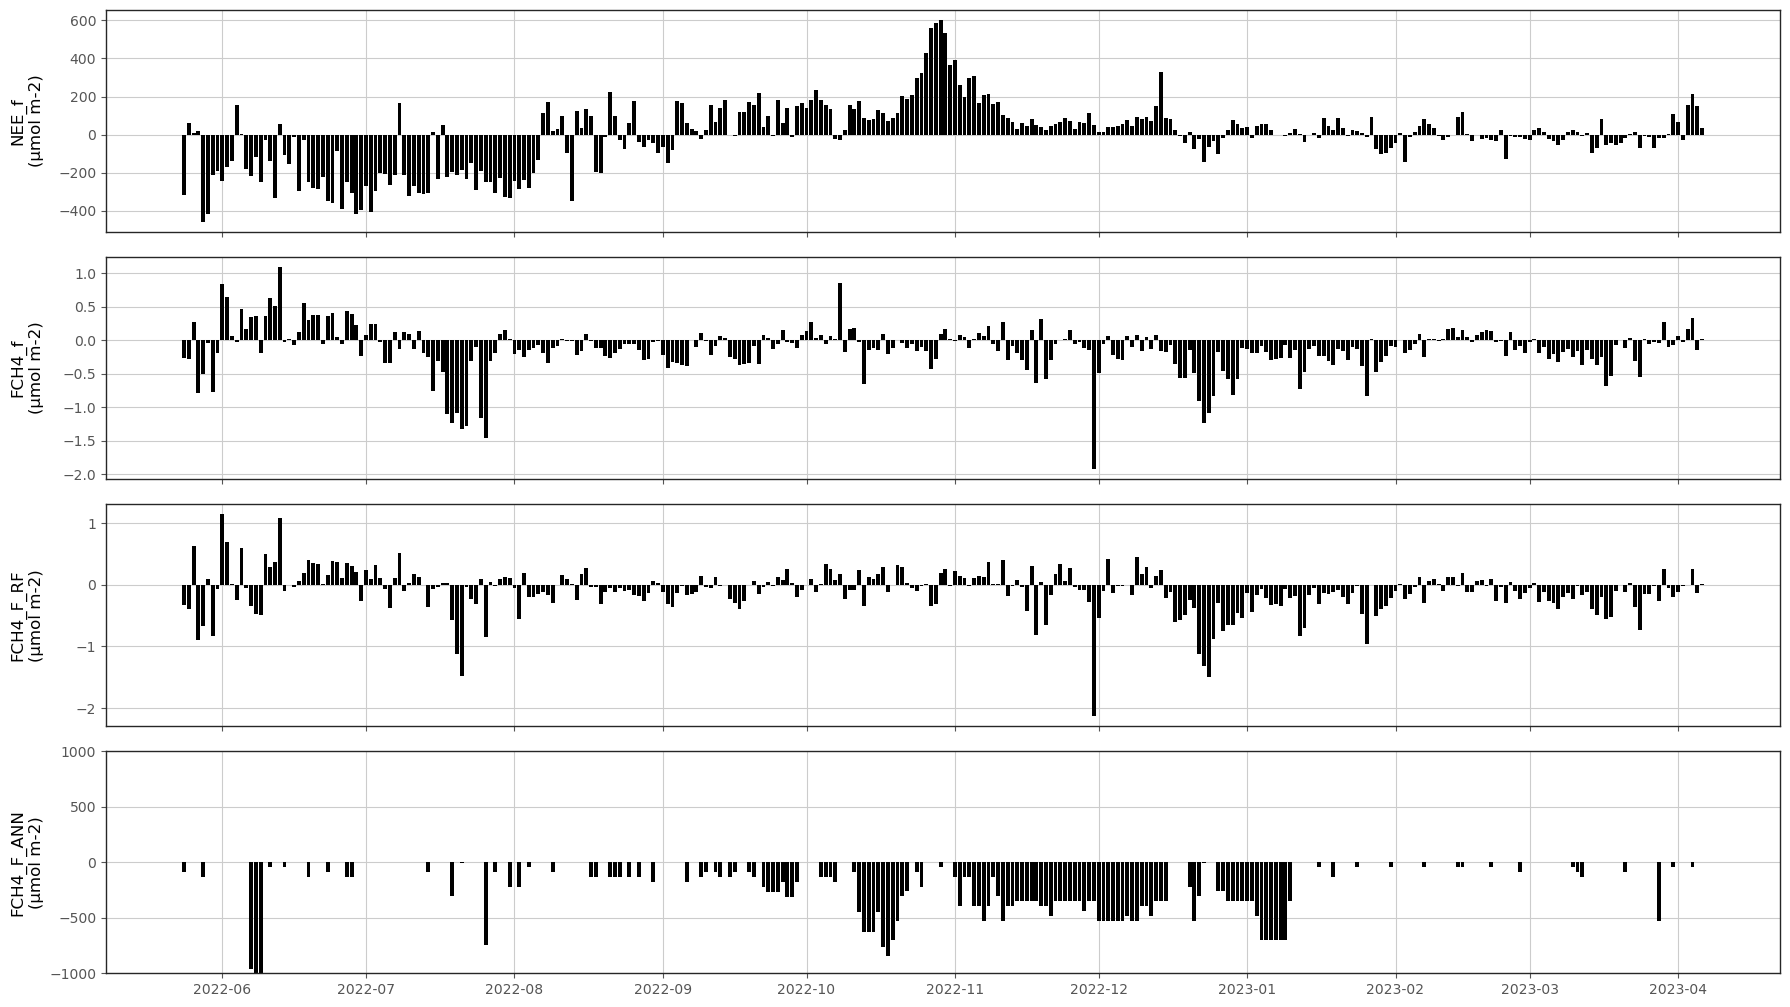

In [60]:
# cols = ['NEE_f', 'Reco', 'GPP_f', 'FCH4_f']
cols = ['NEE_f', 'FCH4_f', 'FCH4_F_RF', 'FCH4_F_ANN']

fig, ax = plt.subplots(len(cols),1, figsize = (10*1.8, 5.65*1.8), sharex = True)

for i in range(len(cols)):
    ax[i].bar(dailysum.index, dailysum[cols[i]], color = 'k', linestyle = 'None')
    ax[i].set(ylabel = cols[i] + '\n(µmol m-2)')

ax[3].set(ylim=[-1000, 1000])
plt.tight_layout()
fig.align_ylabels(ax[:])

# plt.savefig(f'./output/atmos_L3fluxes_{datetime.now().strftime("%Y%m%d")}_ch4modelsums.png', dpi=300)


## Plot methane-gapfill test results

In [8]:
project = 'ATMOS_20230425'

# predictors = ['baseline','basemet','basesoil','baseflux','basemetsoil','basefluxsoil','all']
predictors = ['baseline','basemet','basesoil','baseflux','basefluxvar', 'basemetsoil','basefluxsoil','all'] #0422
labels = ['baseline','+met','+soil','+flux', '+fluxvar', '+metsoil','+fluxsoil','all']

# predictors = ['baseline','basemet','basesoil','baseflux','basefluxvar'] #0425 for now
# labels = ['baseline','+met','+soil','+flux', '+fluxvar']

models = ['ann', 'rf']

tests = pd.concat([pd.read_csv(f'{data_dir}{project}_{subset}/models/{model}/predictors/test_results.csv').assign(pred_subset = subset) for model in models for subset in predictors],
              ignore_index = True)

training = pd.concat([pd.read_csv(f'{data_dir}{project}_{subset}/models/{model}/predictors/training_results.csv').assign(pred_subset = subset, model = model) for model in models for subset in predictors],
                    ignore_index = True)

# training[training['model']=='ann'].boxplot(column = ['nmae', 'pr2'], by='pred_subset')

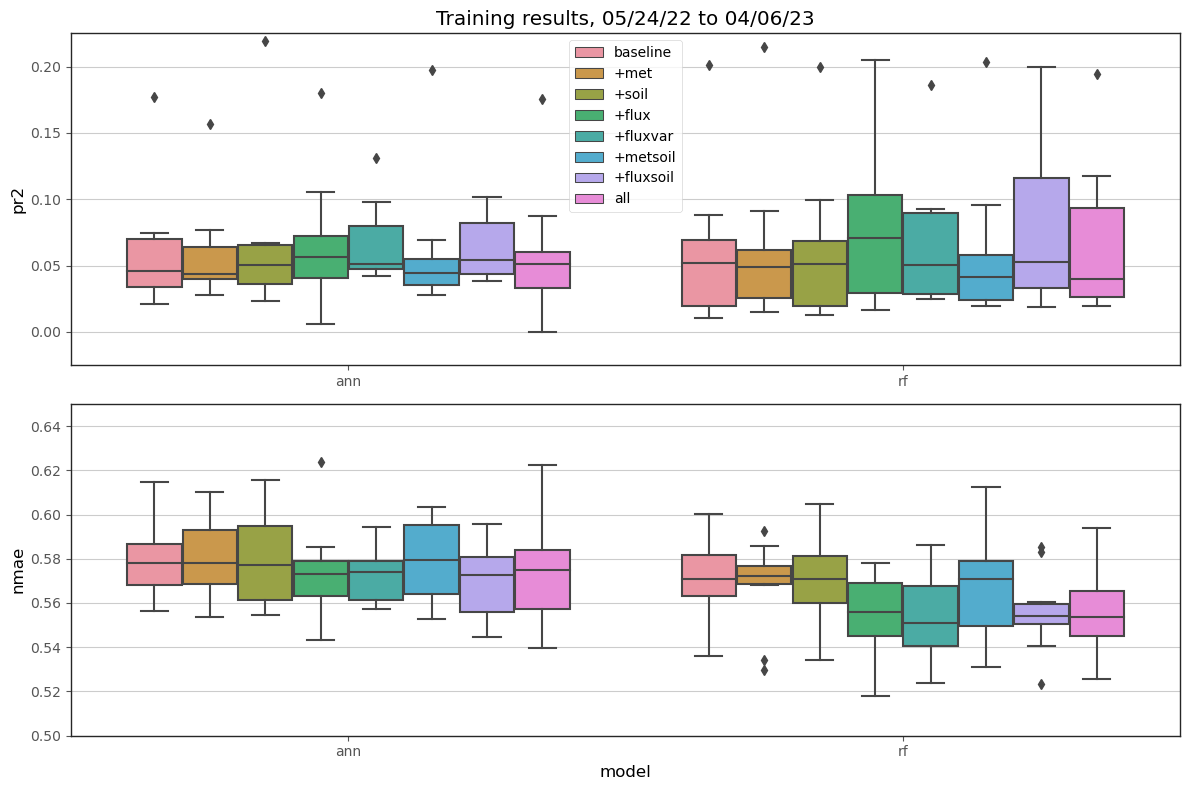

In [10]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
sns.boxplot(x='model', y='pr2', hue='pred_subset', data = training, ax = ax[0])
sns.boxplot(x='model', y='nmae', hue='pred_subset', data = training, ax = ax[1])

ax[1].get_legend().remove()
ax[0].set(ylim = [-0.025, 0.225], xlabel = '', title = 'Training results, 05/24/22 to 04/06/23')
h, l = ax[0].get_legend_handles_labels()
ax[0].legend(handles=h, labels=labels, loc='upper center')
ax[1].set(ylim = [0.5,0.65])
plt.tight_layout()

# plt.savefig(f'./output/methane-gapfill_{datetime.now().strftime("%Y%m%d")}_training0425.png', dpi=300)

/tmp/ipykernel_3152/3151985919.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(labels)
/tmp/ipykernel_3152/3151985919.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(labels)
/tmp/ipykernel_3152/3151985919.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(labels)


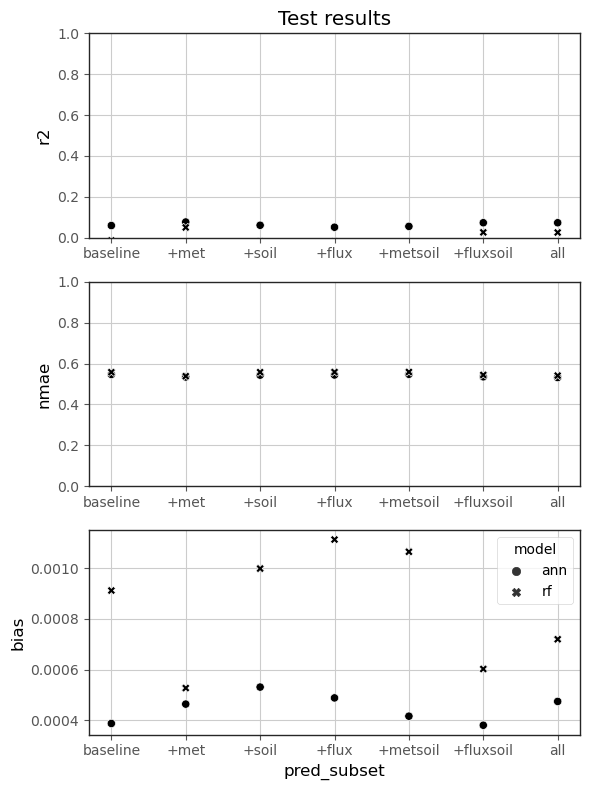

In [6]:
fig, ax = plt.subplots(3,1,figsize = (6, 8))
sns.scatterplot(x='pred_subset',y='r2',style='model', color = 'k', data = tests, ax = ax[0])
sns.scatterplot(x='pred_subset',y='nmae',style='model', color = 'k', data = tests, ax = ax[1])
sns.scatterplot(x='pred_subset',y='bias',style='model', color = 'k', data = tests, ax = ax[2])

ax[0].get_legend().remove()
ax[1].get_legend().remove()
ax[0].set(ylim = [0,1], xlabel = None, title = 'Test results')
ax[1].set(ylim = [0,1], xlabel = None)
# ax[2].set(ylim = [0,1])
ax[0].set_xticklabels(labels)
ax[1].set_xticklabels(labels)
ax[2].set_xticklabels(labels)
plt.tight_layout()

# plt.savefig(f'./output/methane-gapfill_{datetime.now().strftime("%Y%m%d")}_tests.png', dpi=300)

In [87]:
mask1 = l3.columns.str.contains('G_')
mask2 = l3.columns.str.contains('RATIO')
mask3 = l3.columns.str.contains('LAG')
mask4 = l3.columns.str.contains('WD')
l3[l3.columns[mask4]]

,WD_FILTER_NR,WD,WD_SIGMA,WD_FILTER_NREX,WD60,WD_STD60,WD10,WD_STD10
date,,,,,,,,
2022-05-24 13:30:00,18000.0,247.8900,38.4218,0.0,89.0,0.0,63.2,28.9
2022-05-24 14:00:00,18000.0,253.6240,31.8325,0.0,NaN,NaN,NaN,NaN
2022-05-24 14:30:00,18000.0,249.2380,30.6542,0.0,777.7,777.7,72.8,21.9
2022-05-24 15:00:00,18000.0,253.4170,29.3374,0.0,NaN,NaN,NaN,NaN
2022-05-24 15:30:00,18000.0,249.4370,34.7957,0.0,60.9,13.8,71.1,14.6
...,...,...,...,...,...,...,...,...
2022-11-30 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-30 22:30:00,18000.0,83.6459,16.4263,0.0,285.6,9.9,283.0,14.1
2022-11-30 23:00:00,18000.0,80.8154,16.0334,0.0,NaN,NaN,NaN,NaN


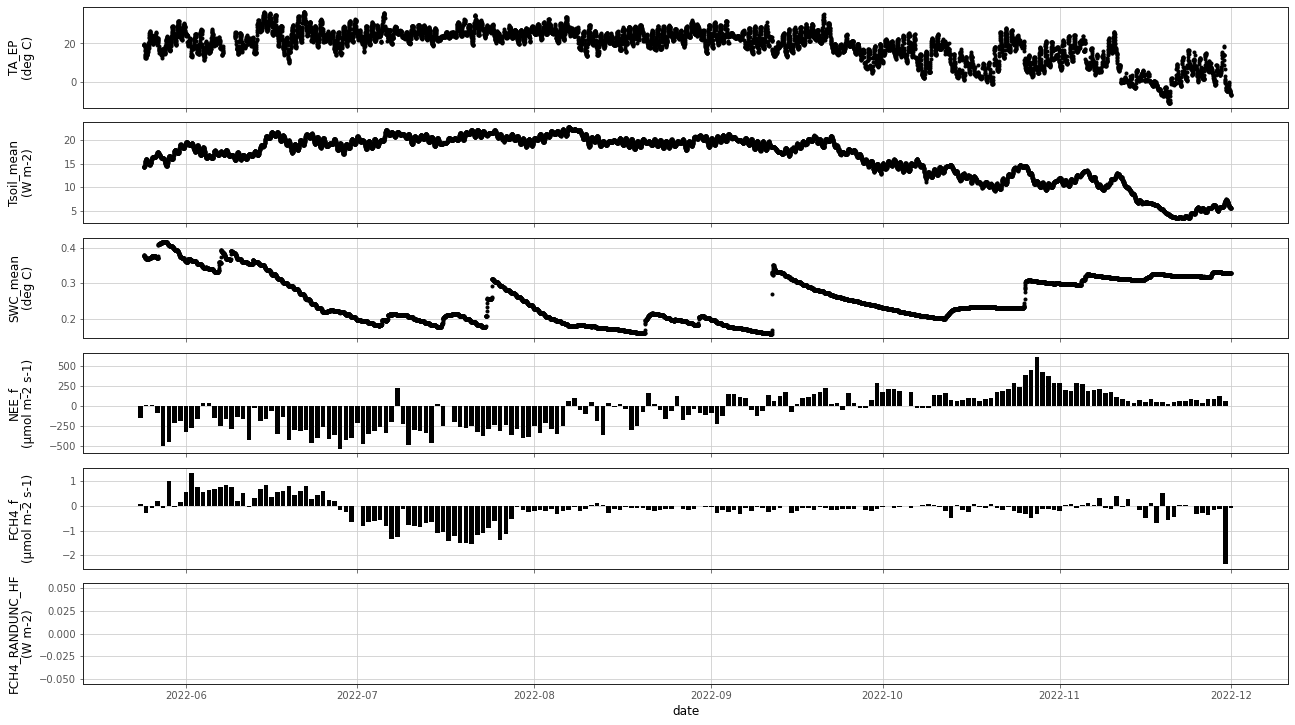

In [7]:
cols = ['TA_EP', 'Tsoil_mean', 'SWC_mean', 'NEE_f', 'FCH4_f', 'FCH4_RANDUNC_HF']

fig, ax = plt.subplots(6,1, figsize = (10*1.8, 5.65*1.8), sharex = True)
ax[0].plot(l3[cols[0]], color = 'k', linestyle='None')
ax[1].plot(l3[cols[1]], color = 'k', linestyle='None')
ax[2].plot(l3[cols[2]], color = 'k', linestyle='None')
ax[3].bar(dailysum.index, dailysum[cols[3]], color = 'k', linestyle='None')
ax[4].bar(dailysum.index, dailysum[cols[4]], color = 'k', linestyle='None')
ax[5].plot(l3[cols[5]], color = 'k', linestyle='None')

ax[0].set(ylabel = cols[0] + '\n(deg C)')
ax[1].set(ylabel = cols[1] + '\n(W m-2)')
ax[2].set(ylabel = cols[2] + '\n(deg C)')
ax[3].set(ylabel = cols[3] + '\n(µmol m-2 s-1)')
ax[4].set(ylabel = cols[4] + '\n(µmol m-2 s-1)')
ax[5].set(ylabel = cols[5] + '\n(W m-2)', xlabel = 'date')
plt.tight_layout()
fig.align_ylabels(ax[:])
# plt.savefig(f'./output/atmos_L3fluxes_{datetime.now().strftime("%Y%m%d%H%M")}.png', dpi=300)

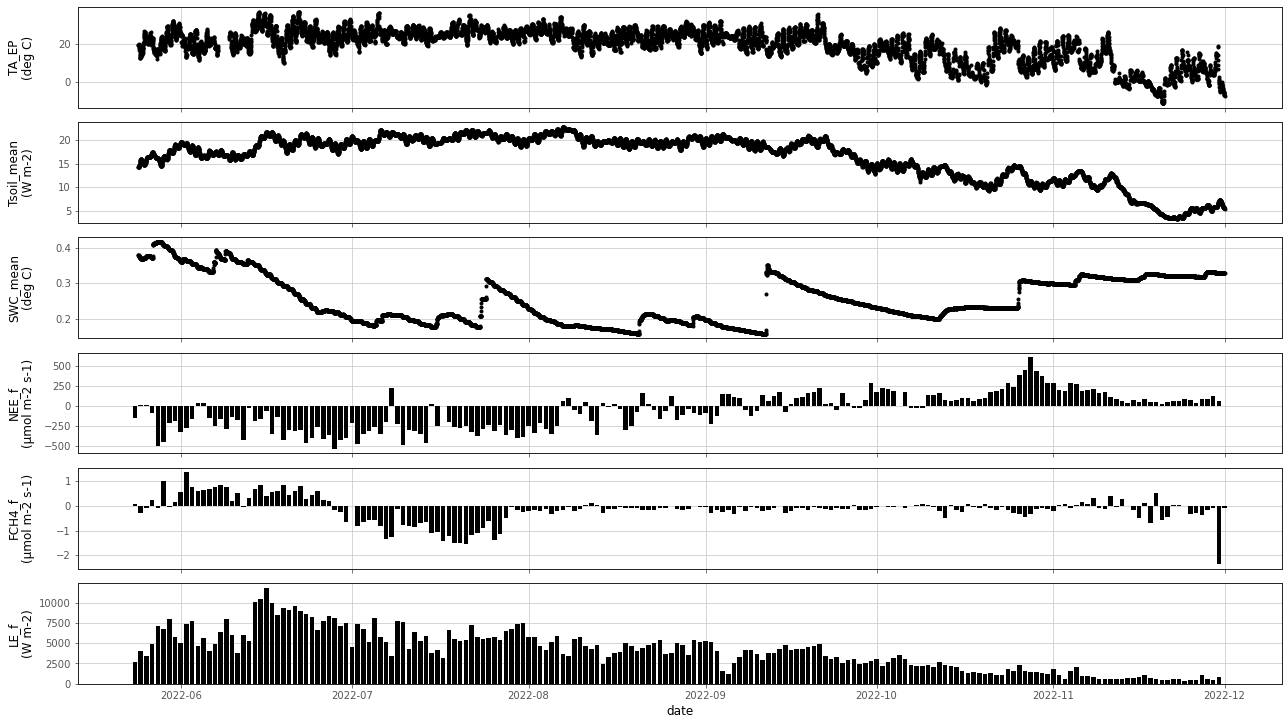

In [4]:
cols = ['TA_EP', 'Tsoil_mean', 'SWC_mean', 'NEE_f', 'FCH4_f', 'LE_f']

fig, ax = plt.subplots(6,1, figsize = (10*1.8, 5.65*1.8), sharex = True)
ax[0].plot(l3[cols[0]], color = 'k', linestyle='None')
ax[1].plot(l3[cols[1]], color = 'k', linestyle='None')
ax[2].plot(l3[cols[2]], color = 'k', linestyle='None')
ax[3].bar(dailysum.index, dailysum[cols[3]], color = 'k', linestyle='None')
ax[4].bar(dailysum.index, dailysum[cols[4]], color = 'k', linestyle='None')
ax[5].bar(dailysum.index, dailysum[cols[5]], color = 'k', linestyle='None')

ax[0].set(ylabel = cols[0] + '\n(deg C)')
ax[1].set(ylabel = cols[1] + '\n(W m-2)')
ax[2].set(ylabel = cols[2] + '\n(deg C)')
ax[3].set(ylabel = cols[3] + '\n(µmol m-2)')
ax[4].set(ylabel = cols[4] + '\n(µmol m-2)')
ax[5].set(ylabel = cols[5] + '\n(W m-2)', xlabel = 'date')
plt.tight_layout()
fig.align_ylabels(ax[:])
# plt.savefig(f'./output/atmos_L3fluxes_{datetime.now().strftime("%Y%m%d%H%M")}.png', dpi=300)